### Importing Packages

In [2]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import pandas as pd
import sys
import os


### Create Random Room Sizes

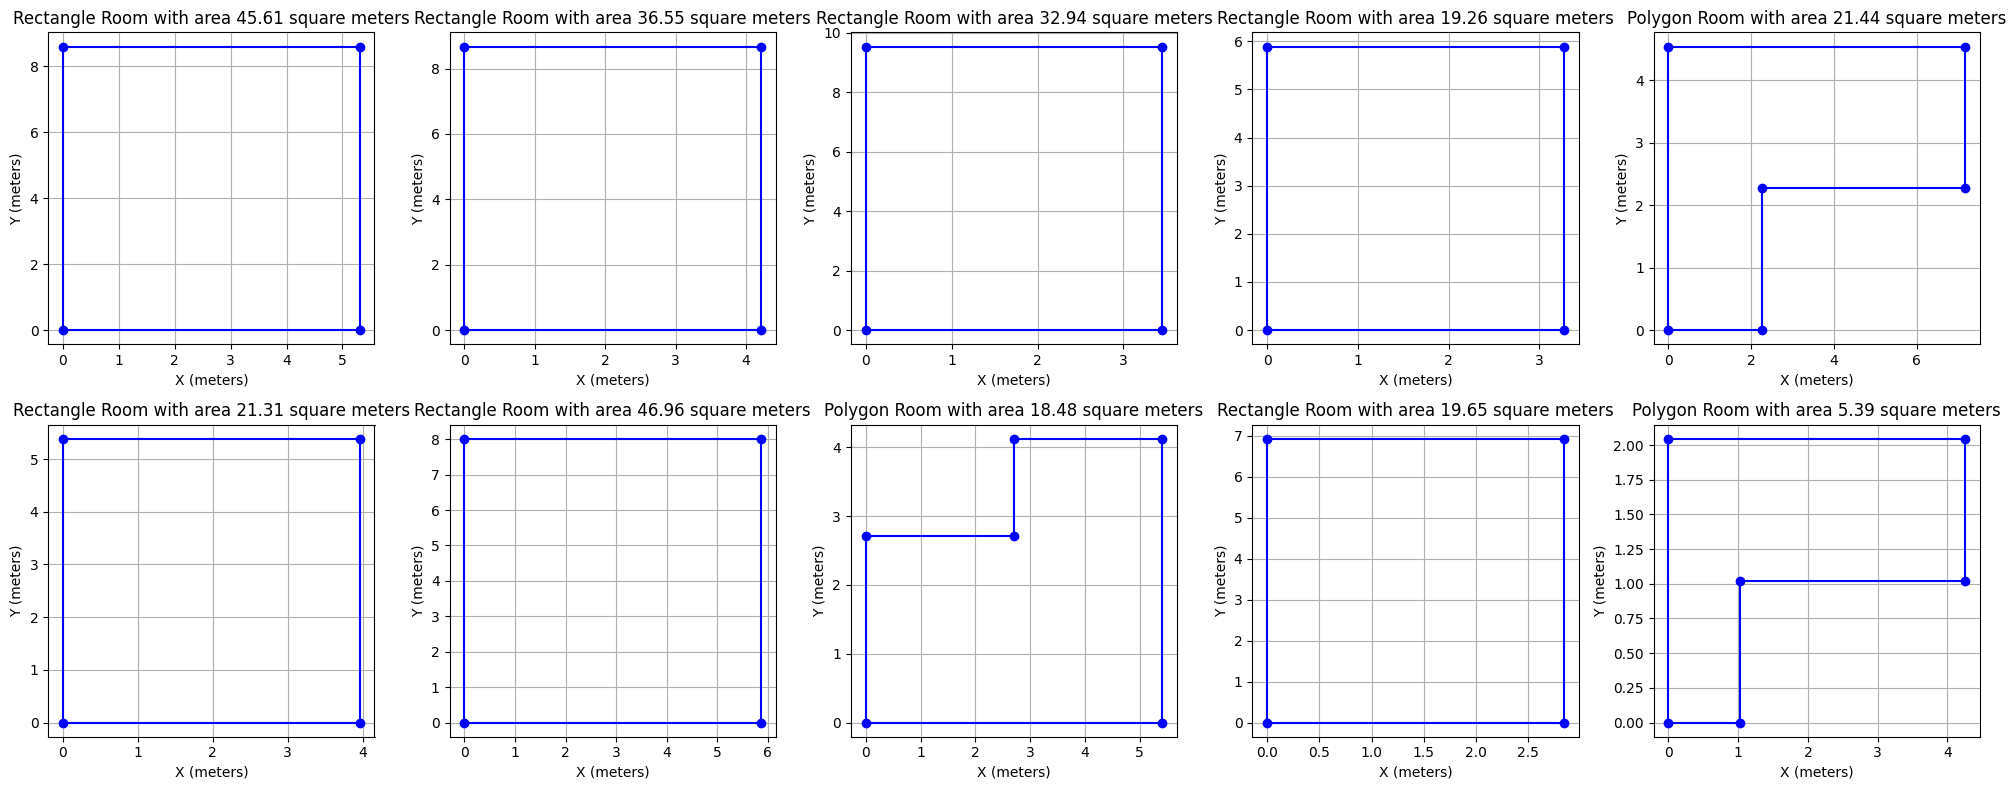


Multiple rooms in DataFrame:


,Length,Width,Corners,Area,Shape Type
0,8.591459,5.308762,"[[0.0, 5.3087617171262345, 5.3087617171262345,...",45.610007,rectangle
1,8.677548,4.211597,"[[0.0, 4.21159721399918, 4.21159721399918, 0.0...",36.546339,rectangle
2,9.537337,3.454181,"[[0.0, 3.4541814914851727, 3.4541814914851727,...",32.943694,rectangle
3,5.892527,3.267860,"[[0.0, 3.2678596198968464, 3.2678596198968464,...",19.255951,rectangle
4,7.172008,4.541690,"[[0.0, 0.0, 7.172007923964708, 7.1720079239647...",21.443253,polygon
5,5.381715,3.960175,"[[0.0, 3.9601752740194907, 3.9601752740194907,...",21.312536,rectangle
6,8.005376,5.865561,"[[0.0, 5.865560967385701, 5.865560967385701, 0...",46.956020,rectangle
7,4.121346,5.412427,"[[0.0, 5.4124267913994935, 5.4124267913994935,...",18.476834,polygon
8,6.917122,2.840851,"[[0.0, 2.8408508551130454, 2.8408508551130454,...",19.650513,rectangle
9,4.256615,2.043631,"[[0.0, 0.0, 4.256614622243977, 4.2566146222439...",5.393583,polygon


In [8]:
def generate_room_with_pattern(length, width, shape_type):
    # Generate the vertices of the room
    if shape_type == "polygon":
        vertices = [
            [0, 0],
            [0, width],
            [length, width],
            [length, width/2],
            [width/2, width/2],
            [width/2, 0]
        ]
    elif shape_type == "rectangle":
        vertices = [
            [0, 0],
            [0, width],
            [length, width],
            [length, 0]
        ]
    
    # Randomly rotate the room by either 0 or 90 degress
    rotation = random.choice([0, 90])

    if rotation == 90:
        new_vertices = []
        for vertex in vertices:
            new_vertices.append([vertex[1], vertex[0]])
        vertices = new_vertices

    # Calculate the actual area of the generated polygon
    actual_area = 0
    for i in range(len(vertices)):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % len(vertices)]
        actual_area += x1 * y2 - x2 * y1
    actual_area = abs(actual_area) / 2

    # Convert the vertices to a numpy array
    corners = np.array(vertices).T

    return {
        "length": length,
        "width": width,
        "corners": corners,
        "area": actual_area,
        "vertices": vertices,
        "shape_type": shape_type
    }

def plot_room(room, ax):
    ax.plot([x for x, y in room["vertices"]] + [room["vertices"][0][0]], [y for x, y in room["vertices"]] + [room["vertices"][0][1]], "b-")
    ax.plot([x for x, y in room["vertices"]] , [y for x, y in room["vertices"]], "bo")
    ax.set_title(f"{room['shape_type'].capitalize()} Room with area {room['area']:.2f} square meters")
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.grid(True)

def store_room_details_in_dataframe(room):
    data = {
        "Length": [room["length"]],
        "Width": [room["width"]],
        "Corners": [room["corners"]],
        "Area": [room["area"]],
        "Shape Type": [room["shape_type"]],
    }
    df = pd.DataFrame(data)
    return df

# Generate multiple rooms
num_rooms = 10
rooms = []
for _ in range(num_rooms):
    length  = random.uniform(3, 10) # 3 to 10 meters
    width  = random.uniform(2, 6) # 2 to 6 meters
    shape_type = random.choice(["polygon", "rectangle"])
    room = generate_room_with_pattern(length, width, shape_type)
    rooms.append(room)

# Plot all the rooms
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, room in enumerate(rooms):
    plot_room(room, axs[i // 5, i % 5])
plt.tight_layout()
plt.show()

# Store the room details in a pandas DataFrame
data = {
    "Length": [room["length"] for room in rooms],
    "Width": [room["width"] for room in rooms],
    "Corners": [room["corners"] for room in rooms],
    "Area": [room["area"] for room in rooms],
    "Shape Type": [room["shape_type"] for room in rooms],
}
df = pd.DataFrame(data)
print("\nMultiple rooms in DataFrame:")
df

(1, 67384)
Orignial WAV:


Simulated propagation to first mic:


List index out of range
(1, 67832)
Orignial WAV:


Simulated propagation to first mic:


(1, 64824)
Orignial WAV:


Simulated propagation to first mic:


List index out of range
List index out of range
(1, 66680)
Orignial WAV:


Simulated propagation to first mic:


List index out of range
List index out of range
(1, 66104)
Orignial WAV:


Simulated propagation to first mic:


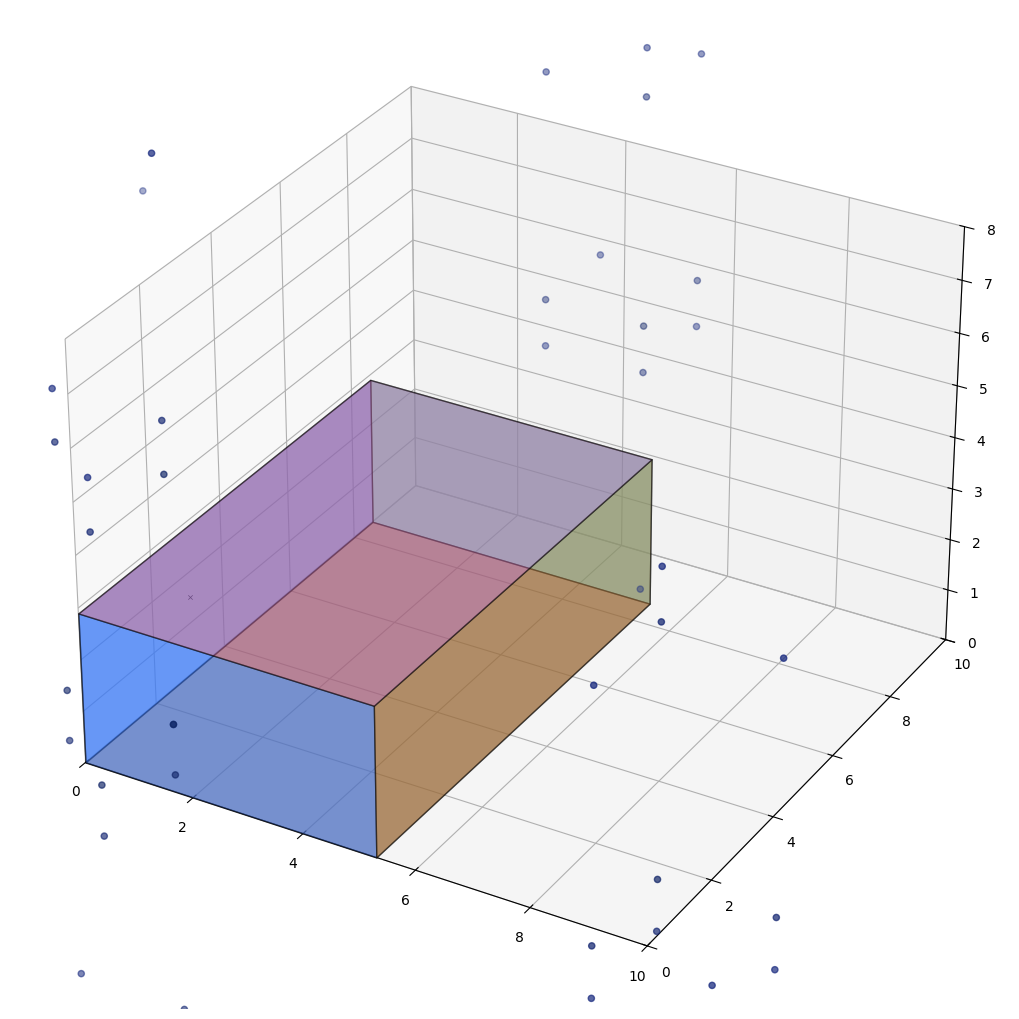

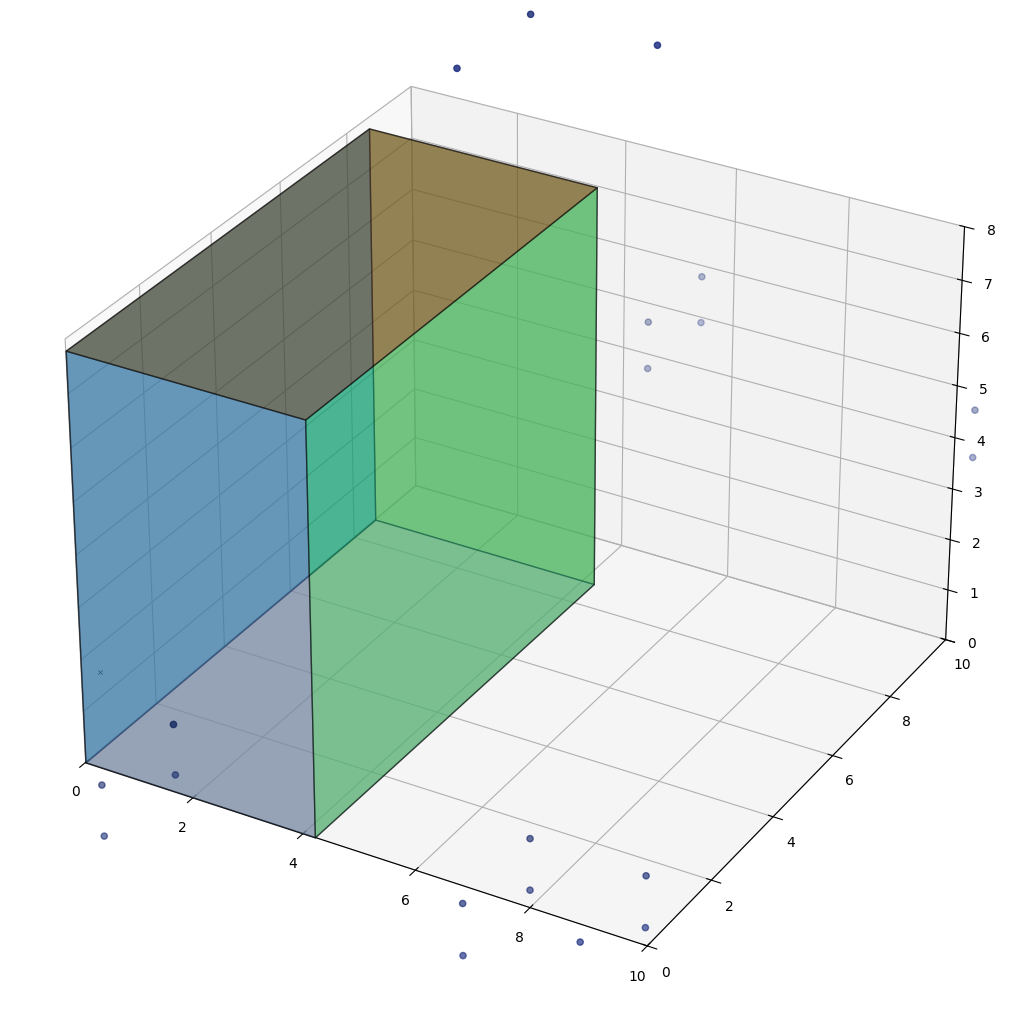

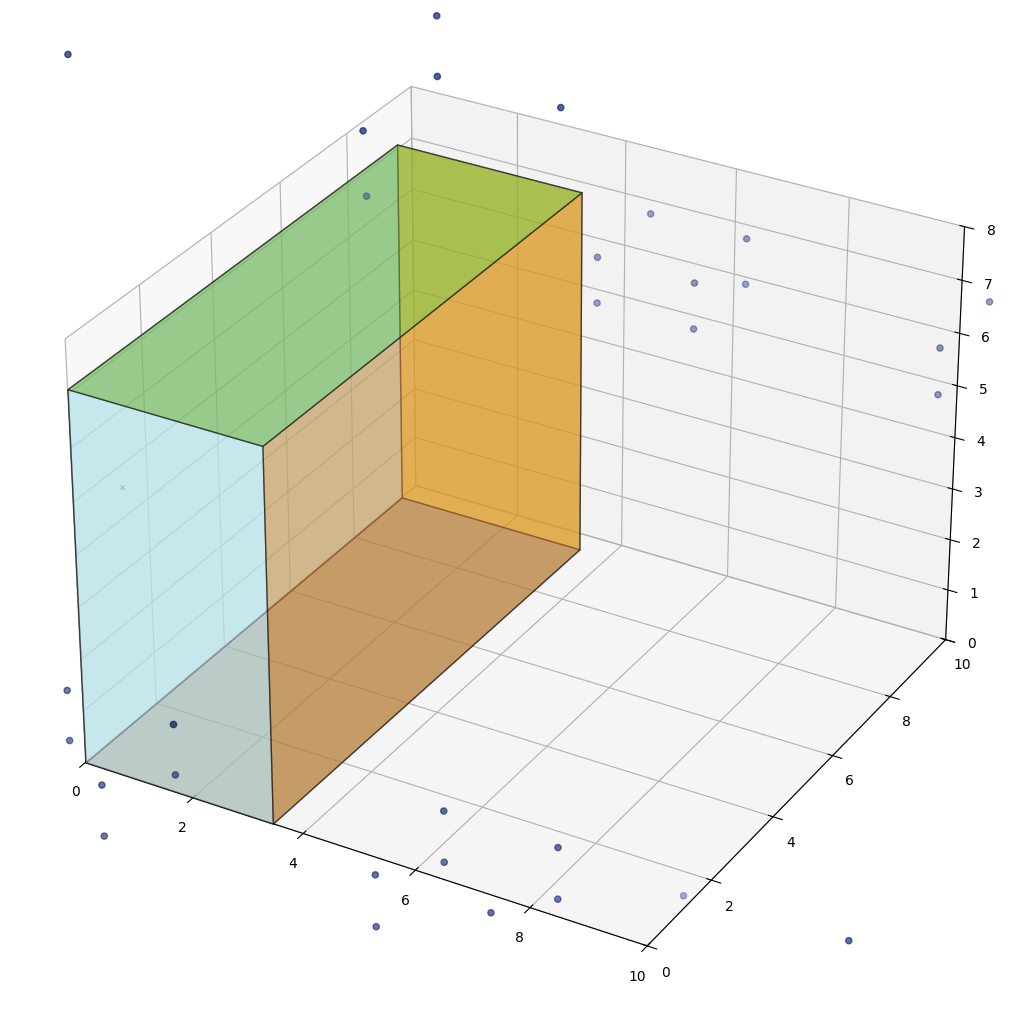

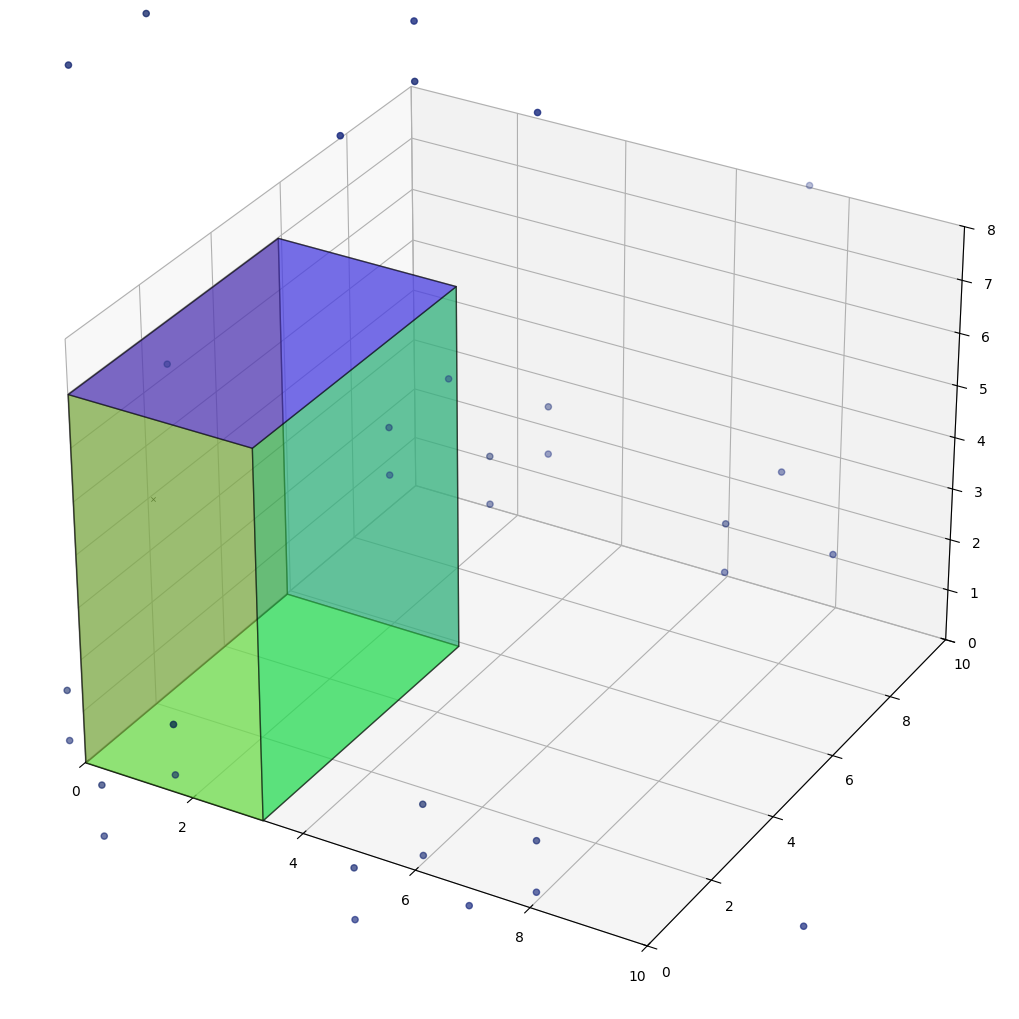

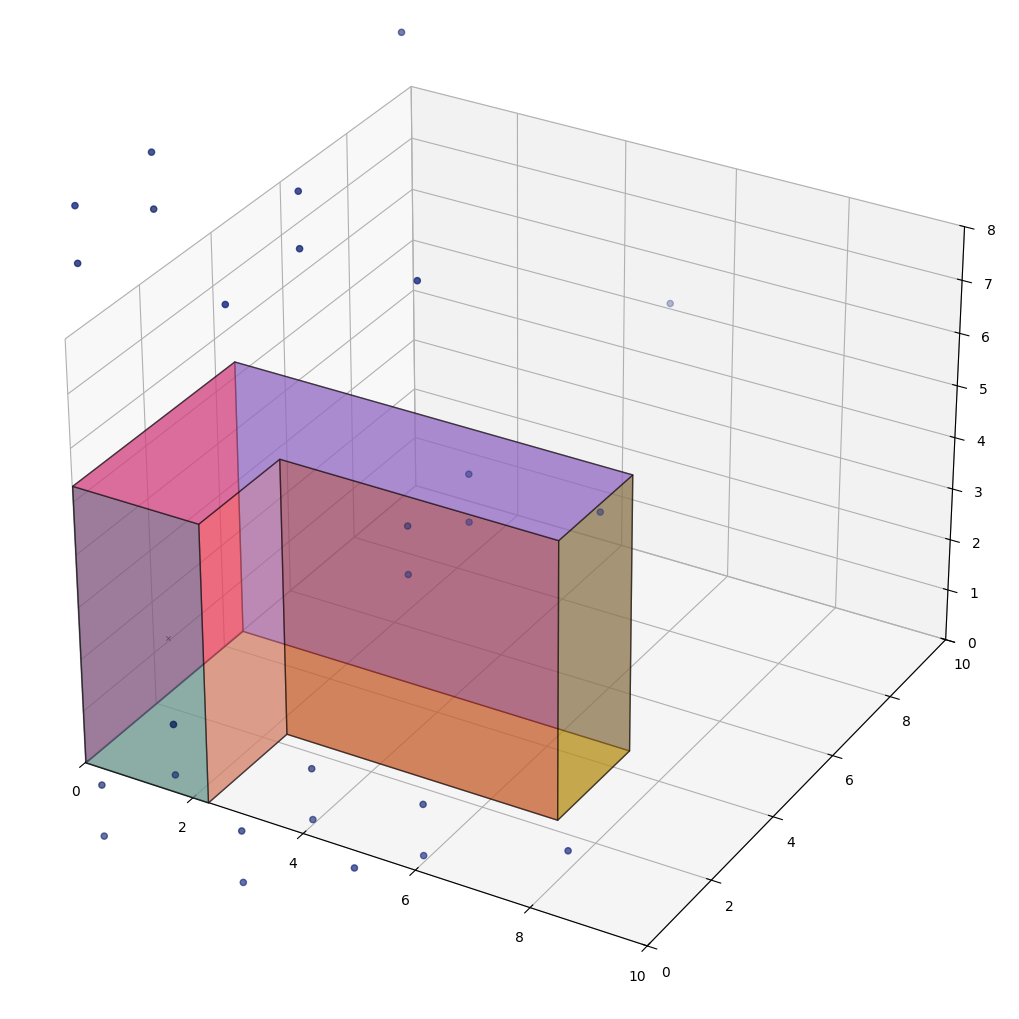

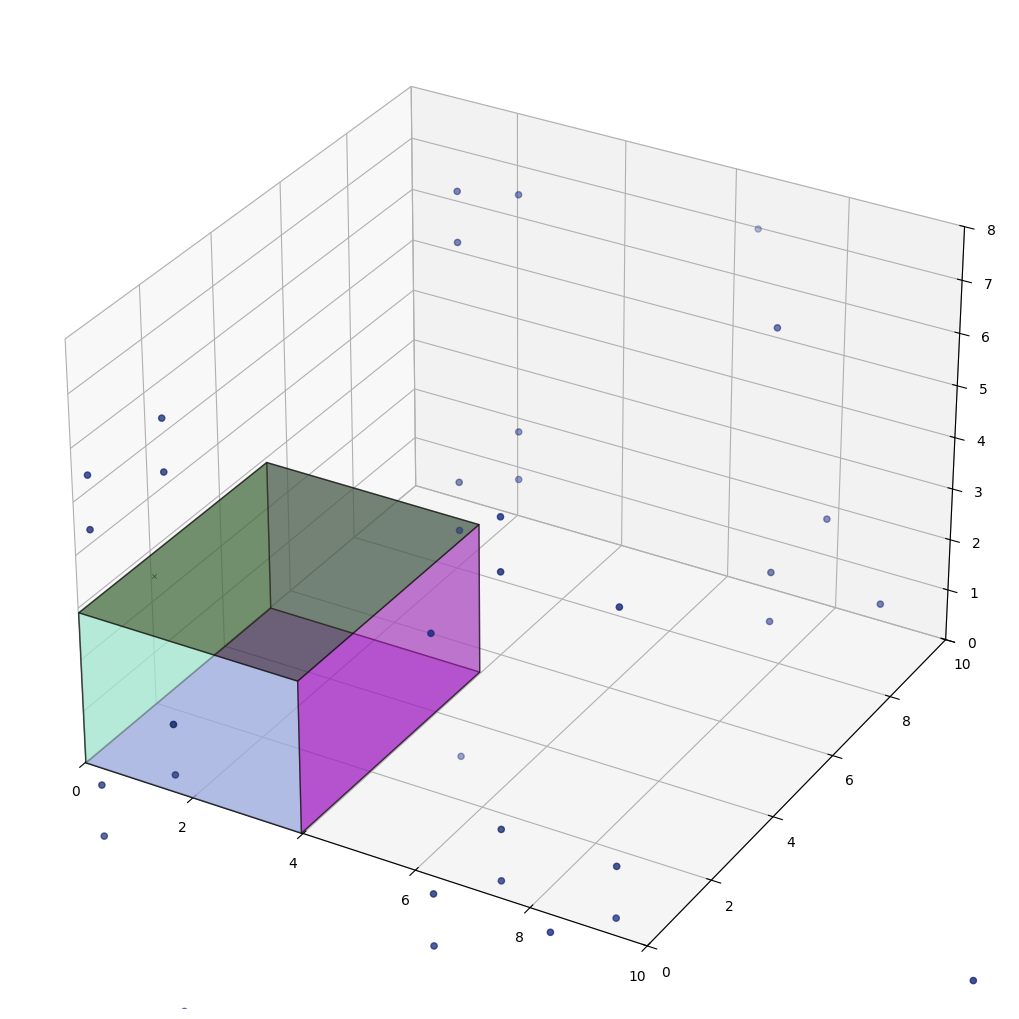

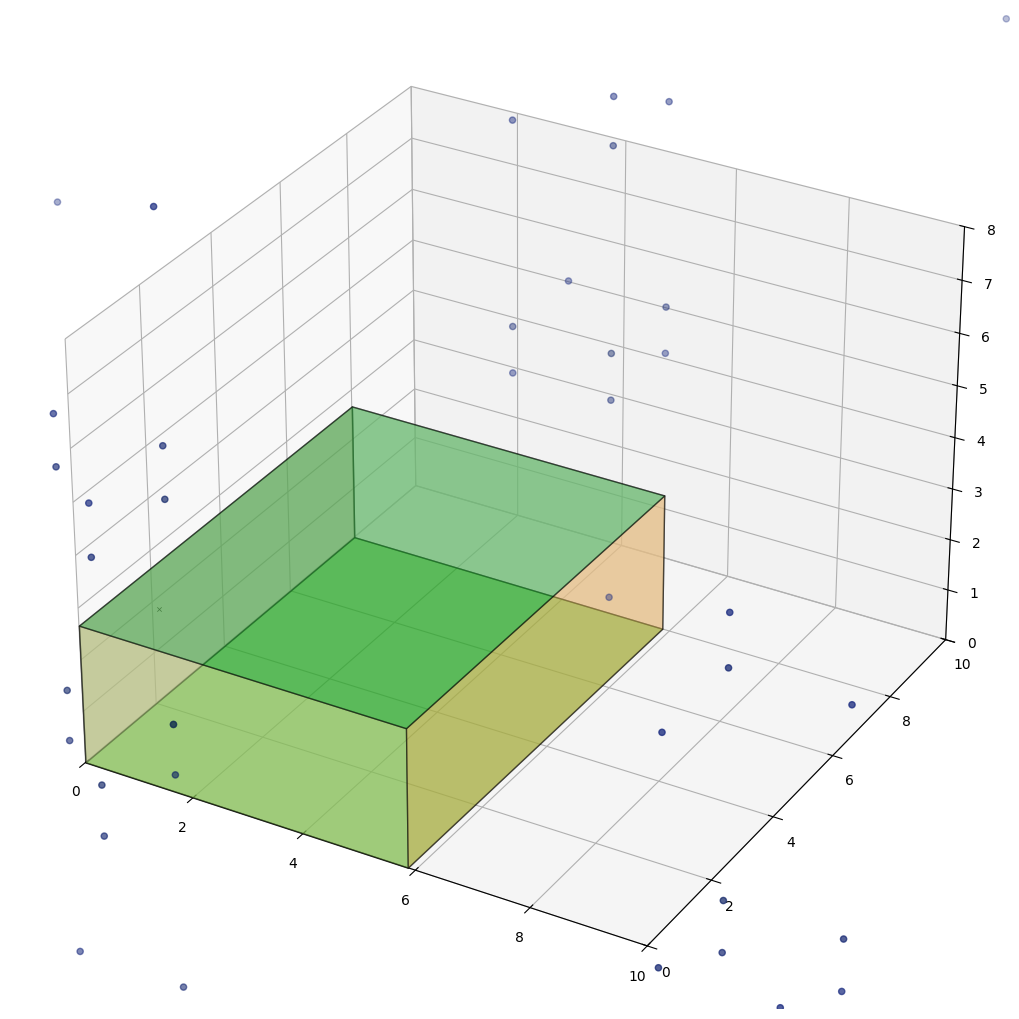

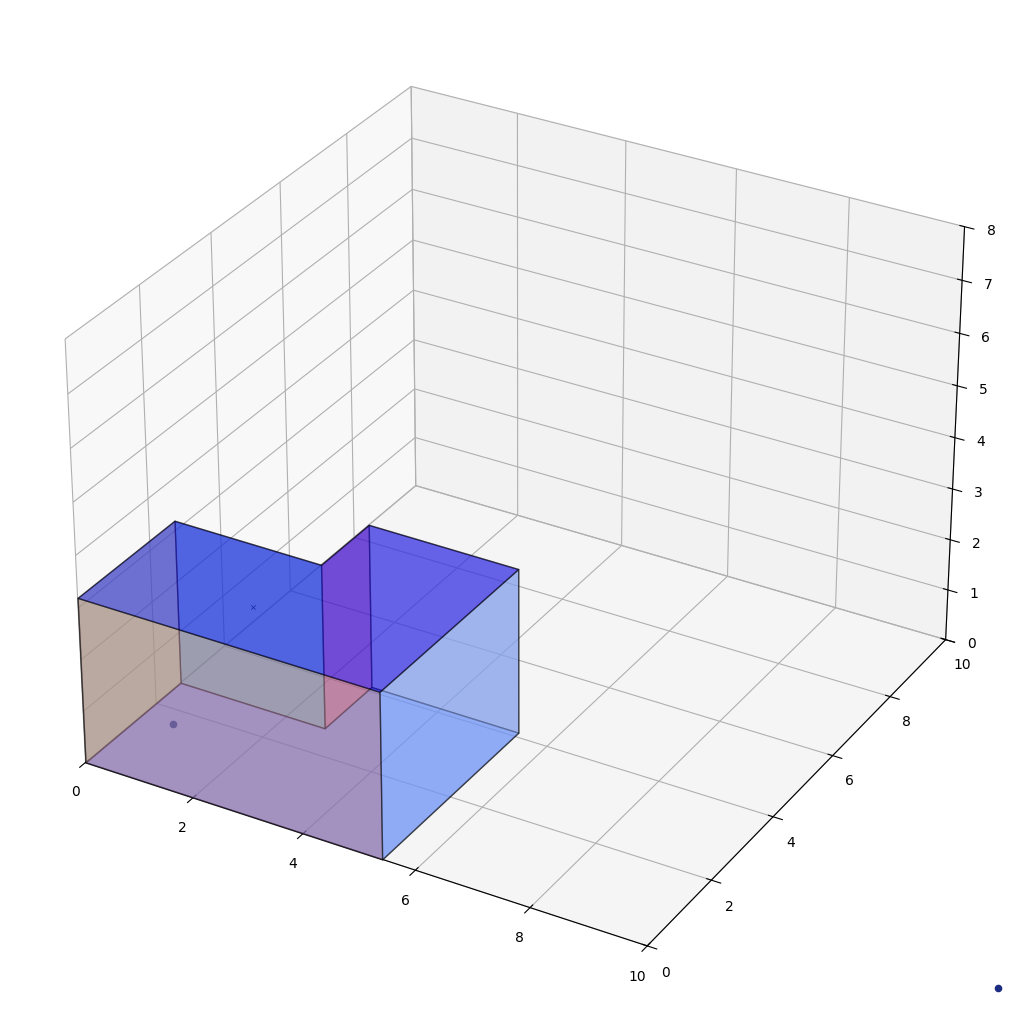

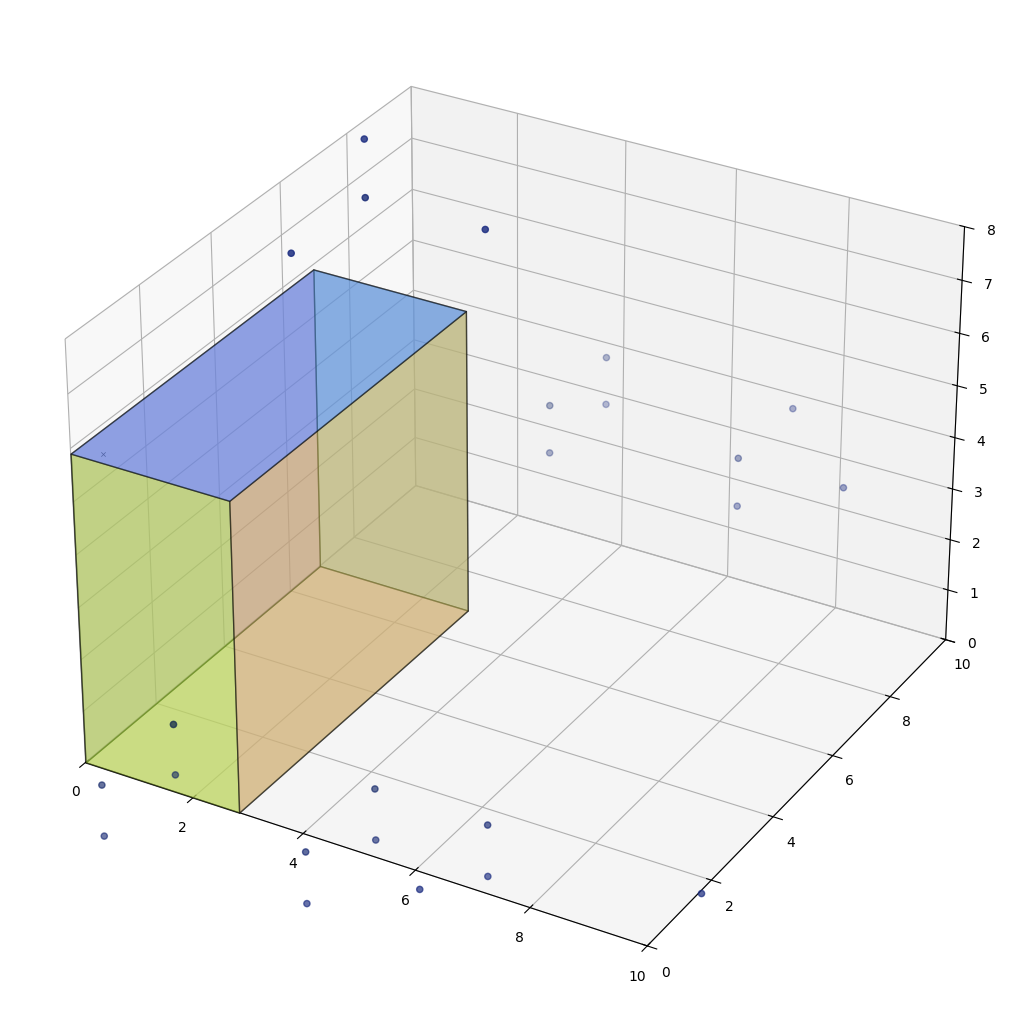

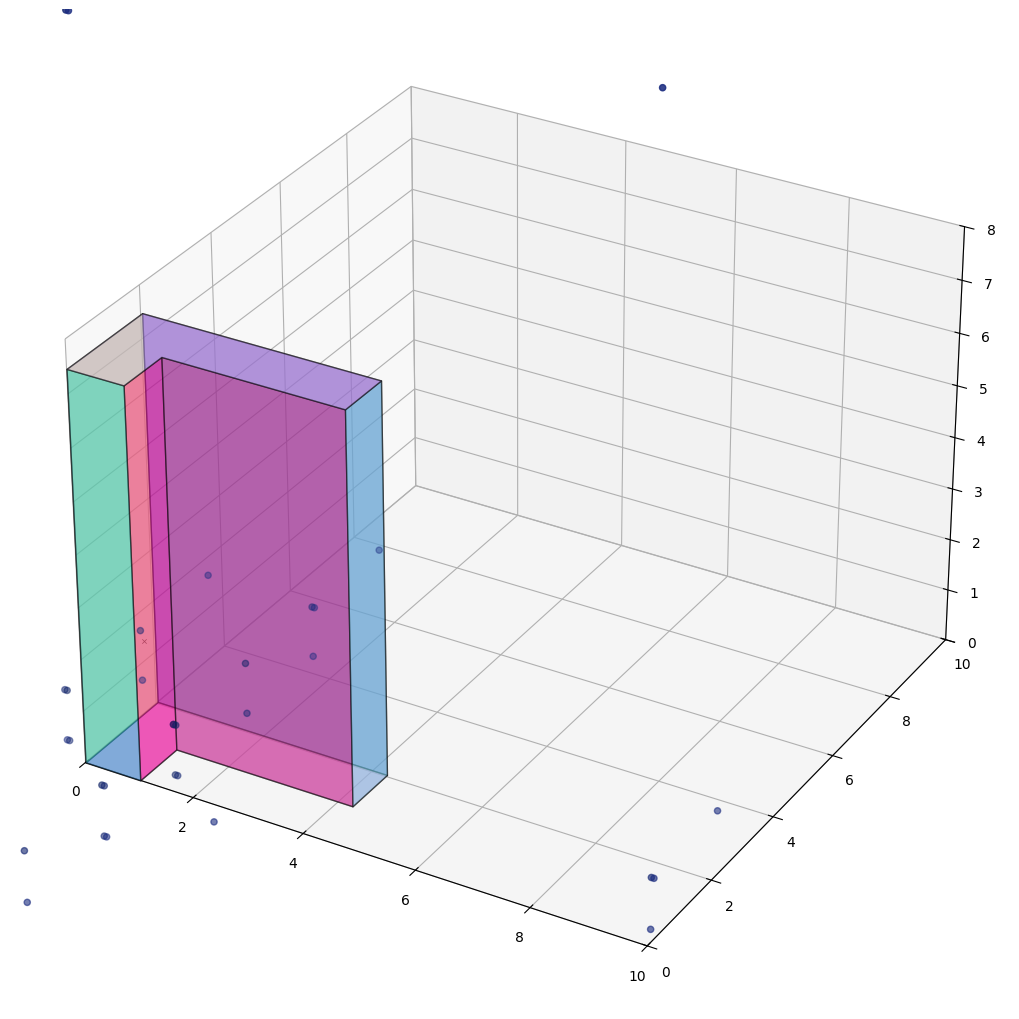

In [ ]:
import IPython.display


input_wav = "../data/arctic_a0010-1.wav"
fs, signal = wavfile.read(input_wav)

for corners in df["Corners"]:
    # Set max order to a low value for a quick (but less accurate) RIR
    room_height = np.random.uniform(2, 8)
    room = pra.Room.from_corners(corners, fs=fs, max_order=3, materials=pra.Material(0.2, 0.15), ray_tracing=True, air_absorption=True)
    room.extrude(room_height, materials=pra.Material(0.2, 0.15))

    # Set the ray tracing parameters
    room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
    source_position = np.array([1., 1., 0.5])
    room.add_source(source_position, signal=signal)

    # Calculate the microphone position within the room
    room_size_x = np.max(corners[:, 0]) - np.min(corners[:, 0])
    room_size_y = np.max(corners[:, 1]) - np.min(corners[:, 1])
    microphone_x = np.random.uniform(np.min(corners[:, 0]) + 0.5, np.max(corners[:, 0]) - 0.5)
    microphone_y = np.random.uniform(np.min(corners[:, 1]) + 0.5, np.max(corners[:, 1]) - 0.5)
    microphone_height = np.random.uniform(0, room_height - 0.5)
    microphone_position  = np.array([microphone_x, microphone_y, microphone_height])

    # Add one microphone array
    R = microphone_position.reshape(-1, 1)
    room.add_microphone(R)

    # Compute image sources
    room.image_source_model()

    # Visualize 3D polyhedron room and image sources
    fig, ax = room.plot(img_order=3)
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
    ax.set_zlim([0, 8])
    fig.set_size_inches(10, 10)

    # Calcualte distance between microphone and speaker
    # distance = np.linalg.norm(microphone_position, source_position)
    # print(f"Distance between microphone and speaker: {distance:.2f} meters")

    try:
        room.simulate()
        print(room.mic_array.signals.shape)
    except:
        print("List index out of range")
        continue

    # Original signal
    print("Orignial WAV:")
    IPython.display.display(IPython.display.Audio(signal, rate=fs))

    print("Simulated propagation to first mic:")
    IPython.display.display(IPython.display.Audio(room.mic_array.signals[0, :], rate=fs))